## Testing a metric to calculate the effect of crowding on color ##


In [1]:
# Some modules you're likely to want .. add whatever is needed.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
import os
import healpy as hp
from scipy.interpolate import griddata, interp1d, interpn

%matplotlib inline   
# %matplotlib notebook

In [2]:
# Import MAF
import rubin_sim.maf as maf

You need to connect to the opsim output, so let's do that first. <br>
It's easy to use the current baseline simulation included with $RUBIN_SIM_DATA_DIR, so let's start with that.

In [3]:
from rubin_sim.data import get_baseline

opsim_fname = get_baseline()
print(opsim_fname)

runName = os.path.split(opsim_fname)[-1].replace('.db', '')
print(runName)

/sims_maf/rubin_sim_data/sim_baseline/baseline_v2.0_10yrs.db
baseline_v2.0_10yrs


In [4]:
# Connect to the database so we can use it with MAF.
opsim_db = maf.OpsimDatabase(opsim_fname)

Now set up to work with our Metric. Remember that the Metric will work on a single DataSlice at a time -- so 
*all* of (and *only*) the observation information it receives will be the visits relevant to this test_ra/test_dec location.

This metric builds on the existing single-band CrowdingMagUncertMetric.

In [5]:
%psource maf.metrics.CrowdingMagUncertMetric

class CrowdingMagUncertMetric(BaseMetric):
    """
    Given a stellar magnitude, calculate the mean uncertainty on the magnitude from crowding.
    """
    def __init__(self, rmag=20., seeingCol='seeingFwhmGeom', units='mag',
                 metricName=None, filtername='r', maps=['StellarDensityMap'], **kwargs):
        """
        Parameters
        ----------
        rmag : float
            The magnitude of the star to consider.

        Returns
        -------
        float
            The uncertainty in magnitudes caused by crowding for a star of rmag.
        """

        self.filtername = filtername
        self.seeingCol = seeingCol
        self.rmag = rmag
        if metricName is None:
            metricName = 'CrowdingError at %.2f' % (rmag)
        super().__init__(col=[seeingCol], maps=maps, units=units,
                         metricName=metricName, **kwargs)

    def run(self, dataSlice, slicePoint=None):
        magVector = slicePoint[f'starMapBins_{self.filtername}'

In [6]:
# will need single-band crowding error as well
def _compCrowdError(magVector, lumFunc, seeing, singleMag=None):
        """
        Compute the crowding error for each observation

        Parameters
        ----------
        magVector : np.array
            Stellar magnitudes.
        lumFunc : np.array
            Stellar luminosity function.
        seeing : float
            The best seeing conditions. Assuming forced-photometry can use the best seeing conditions
            to help with confusion errors.
        singleMag : float (None)
            If singleMag is None, the crowding error is calculated for each mag in magVector. If
            singleMag is a float, the crowding error is interpolated to that single value.

        Returns
        -------
        np.array
            Magnitude uncertainties.


        Equation from Olsen, Blum, & Rigaut 2003, AJ, 126, 452
        """

        lumAreaArcsec = 3600.**2
        lumVector = 10**(-0.4*magVector)
        coeff=np.sqrt(np.pi/lumAreaArcsec)*seeing/2.
        myIntegral = (np.add.accumulate((lumVector**2*lumFunc)[::-1]))[::-1]
        temp = np.sqrt(myIntegral)/lumVector
        if singleMag is not None:
            interp = interp1d(magVector, temp)
            temp = interp(singleMag)

        crowdError = coeff*temp

        return crowdError

# compute color error for a given magnitude vector, joint LF, and seeing in two bands
def _compColorCrowdError(magVector1, magVector2, lumFunc12, seeing1, seeing2, singleMag1=None, singleMag2=None):
        """
        Compute the crowding error for each observation

        Parameters
        ----------
        magVector1 : np.array
            Stellar magnitudes in band 1.
        magVector2 : np.array
            Stellar magnitudes in band 2.
        lumFunc12 : np.array (2D)
            Joint stellar luminosity function in bands 1 and 2.
        seeing1 : float
            Seeing in band 1.
        seeing2 : float
            Seeing in band 2.
        singleMag1 : float (None)
            If singleMag is None, the crowding error is calculated for each mag in magVector. If
            singleMag is a float, the crowding error is interpolated to that single value.

        Returns
        -------
        np.array
            Magnitude uncertainties.


        Equation from Olsen, Blum, & Rigaut 2003, AJ, 126, 452
        """

        lumAreaArcsec = 3600.**2
        lumVector1, lumVector2 = np.meshgrid(10**(-0.4*magVector1), 10**(-0.4*magVector2))

        coeff=np.sqrt(np.pi/lumAreaArcsec)*np.min([seeing1,seeing2])/2.
        innerInt = np.add.accumulate(np.flip(lumVector1*lumFunc12),axis=1)
        outerInt = np.add.accumulate(np.flip(lumVector2)*innerInt,axis=0)
        int2d = np.flip(outerInt)

        temp = np.sqrt(int2d)/np.sqrt(lumVector1*lumVector2)

        crowdError12 = coeff*temp
        crowdError1 = _compCrowdError(magVector1,np.sum(lumFunc12,axis=0),seeing1)
        crowdError2 = _compCrowdError(magVector2,np.sum(lumFunc12,axis=1),seeing2)
        ce1, ce2 = np.meshgrid(crowdError1,crowdError2)
        
        colCrowdError = np.sqrt(ce1**2 + ce2**2 - 2*crowdError12**2)
        if singleMag1 is not None and singleMag2 is not None:
            interp = interp1d(magVector1, crowdError1)
            crowdError1 = interp(singleMag1)
            interp = interp1d(magVector2, crowdError2)
            crowdError2 = interp(singleMag2)
            #xvec,yvec = np.meshgrid(magVector1,magVector2)
            interp = interpn((magVector1,magVector2),colCrowdError,(singleMag1,singleMag2))
            colCrowdError = interp

        return crowdError1, crowdError2, colCrowdError


# returns single-mag error in each band and the error in color
class CrowdingMagColorUncertMetric(maf.BaseMetric):
    """
    Given a stellar magnitude in two bands, calculate the mean uncertainty on the magnitude and color from crowding.
    """
    def __init__(self, mag1=20., mag2=20., seeingCol='seeingFwhmGeom', units='mag',
                 metricName=None, filter1name='g', filter2name='r', lfpath='~/lsst/SMWLV-metrics/notebooks/', **kwargs):
        """
        Parameters
        ----------
        mag1 : float
            The magnitude of the star in filter1 to consider.
        mag2 : float
            The magnitude of the star in filter2 to consider.


        Returns
        -------
        float
            The uncertainty in magnitudes caused by crowding for a star of mag1 and mag2 and color mag1-mag2.
        """

        colors = ['ug','ur','ui','uz','gr','gi','gz','ri','rz','iz']     
        if filter1name + filter2name not in colors:
            print('Color '+ filter1name + filter2name + ' not in list.  Please pick one of ' + str(colors)) 
            return
        self.filter1name = filter1name
        self.filter2name = filter2name
        self.seeingCol = seeingCol
        self.mag1 = mag1
        self.mag2 = mag2
        self.colorname = filter1name + filter2name
        self.jointlf_file = lfpath + 'jointlf_' + self.colorname + '_wVecs.fits'
        jointlf = Table.read(os.path.expanduser(self.jointlf_file))
        jointlf['ring64'] = hp.nest2ring(64,jointlf['nest64'])
        self.jointlf = jointlf
        self.magvec1 = np.array(self.jointlf.meta['MAGS0'])
        self.magvec2 = np.array(self.jointlf.meta['MAGS1'])
        self.maggrid1, self.maggrid2 = np.meshgrid(self.magvec1,self.magvec2)
        
        if metricName is None:
            metricName = 'CrowdingColorError at %s = %.2f %s = %.2f' % (filter1name,mag1,filter2name,mag2)
        super().__init__(col=[seeingCol,'filter'], units=units,
                         metricName=metricName, **kwargs)


        
    def run(self, dataSlice, slicePoint=None):

        lf12t = self.jointlf[self.jointlf['ring64'] == slicePoint['sid']]
        if len(lf12t)>0:
            lf12 = griddata((lf12t[self.filter1name],lf12t[self.filter2name]),lf12t['n'],(self.maggrid1, self.maggrid2),fill_value=0.)                                                        
            # Magnitude and color uncertainty given crowding
            sig1, sig2, sig12 = _compColorCrowdError(self.magvec1, self.magvec2, lf12, 
                                               dataSlice[self.seeingCol].min(), 
                                               dataSlice[self.seeingCol].min(),
                                               singleMag1=self.mag1, singleMag2=self.mag2)
        else:
            sig1, sig2, sig12 = 0., 0., 0.

        #result = sig12
        result = {'sig1': sig1, 'sig2': sig2, 'sig12': sig12}
        
        return result
    
    def reduce_sig1(self, metricValue):
        return metricValue['sig1']
    
    def reduce_sig2(self, metricValue):
        return metricValue['sig2']

    def reduce_sig12(self, metricValue):
        return metricValue['sig12']

In [7]:
slicer = maf.HealpixSlicer(nside=64)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


The typical way to use this metric with a slicer within MAF would be as follows: 

In [8]:
# Set up the metric
metric = CrowdingMagColorUncertMetric()

In [9]:
metric.name

'CrowdingColorError at g = 20.00 r = 20.00'

In [10]:
# Define a sqlconstraint, if we need to just use a (large) subset of the opsim visits
sqlconstraint = '(filter = "g" or filter = "r")'   # no constraint, make all visits available


In [11]:
# We already defined the slicer - combine the metric, slicer and sqlconstraint in a MetricBundle:
bundle = maf.MetricBundle(metric, slicer, sqlconstraint, runName=runName)

In [12]:
%%time
# Pass the bundle (along with any other bundles to be run on this opsim) to a MetricBundleGroup in order to
# calculate the metric bundle values.
g = maf.MetricBundleGroup({'test_metric': bundle}, opsim_db, outDir='test', resultsDb=None)
# And calculate the metric
g.runAll()

Querying database observations with constraint (filter = "g" or filter = "r") for columns ['filter', 'fieldRA', 'fieldDec', 'rotSkyPos', 'seeingFwhmGeom']
Found 682668 visits
Running:  ['test_metric']


<ipython-input-6-a24914e6906b>:86: RuntimeWarning: invalid value encountered in sqrt
  colCrowdError = np.sqrt(ce1**2 + ce2**2 - 2*crowdError12**2)


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 25min 23s, sys: 6.66 s, total: 25min 30s
Wall time: 25min 31s


Plotting figures with "(filter = "g" or filter = "r")" constraint now.


/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/plots/plotHandler.py:518: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')
0.0 180.0 -180.0 180.0
/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make 207 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
0.0 180.0 -180.0 180.0
/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make 345 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
0.0 180.0 -180.0 180.0
/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make 339 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0

Plotting complete.


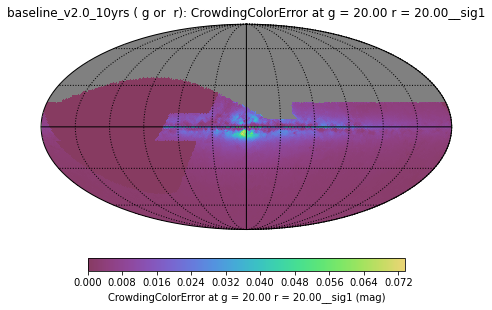

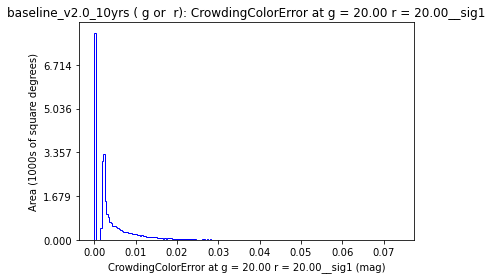

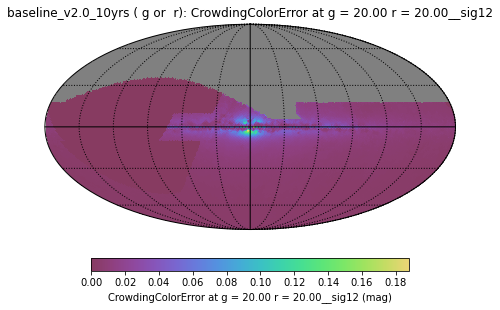

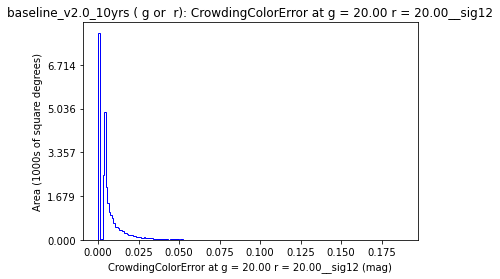

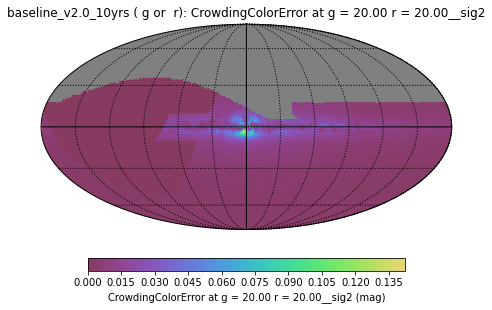

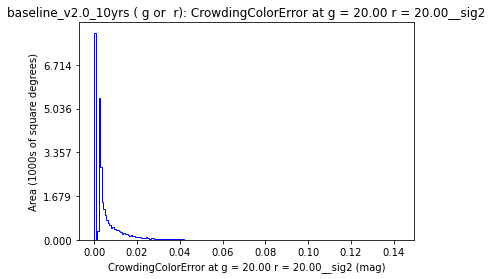

In [13]:
g.plotAll(closefigs=False)